In [1]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "args_test" / "gpulab" / "args_test2")


# ONE TO ONE

                                            Name             Args  \
0                            nai_block_per_shift              128   
1                            nai_block_per_shift              256   
2                     nai_shuffle_multimat_right                4   
3                     nai_shuffle_multimat_right                8   
4   nai_shuffle_multimat_right_work_distribution                4   
5   nai_shuffle_multimat_right_work_distribution                8   
9                      nai_shuffle_multirow_both            4_8_4   
13                     nai_shuffle_multirow_both            8_8_4   
7                      nai_shuffle_multirow_both            4_4_4   
14                    nai_shuffle_multirow_right              4_4   
16                    nai_shuffle_multirow_right              8_4   
15                    nai_shuffle_multirow_right              4_8   
18                            nai_warp_per_shift               16   
19                            nai_

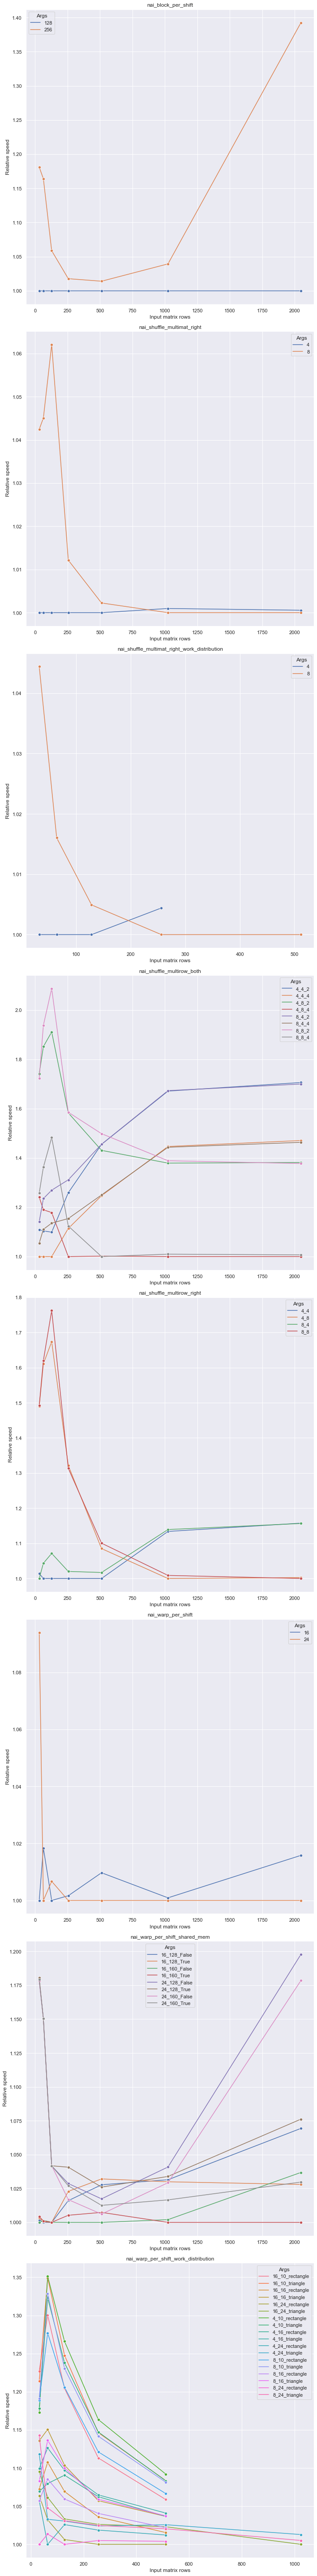

In [2]:
group = benchmark.groups["one_to_one"]

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

# data = data[data["Input matrix rows"] >= 256]

grouped = data.groupby(["Name", "Args", "Input matrix rows"])



kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

min_times = results.groupby(["Name", "Input matrix rows"])["Kernel time"].min().to_frame("Kernel time").reset_index()


def speedup(row):
    min_time = min_times[(min_times["Name"] == row["Name"]) & (min_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return row["Kernel time"] / min_time

results["Relative speed"] = results.apply(speedup, axis=1)



sns.set(rc={'figure.figsize': (10, 80)})
fig, axs = plt.subplots(nrows=results["Name"].nunique())
for idx, name in enumerate(sorted(results["Name"].unique())):
    filtered_result = results[results["Name"] == name]
    ax = sns.lineplot(data=filtered_result, x="Input matrix rows", y="Relative speed", hue="Args", marker='o', ax=axs[idx])

    ax.set_title(f"{name}")
fig.tight_layout()

best_args = results.groupby(["Name", "Args"])["Relative speed"].sum().to_frame("Total relative time").reset_index().sort_values("Total relative time")
print(best_args.groupby(["Name"]).head(3).sort_values("Name", kind="stable"))

# ONE TO MANY

                                            Name      Args  \
1                     nai_shuffle_multimat_right       4_2   
3                     nai_shuffle_multimat_right       8_2   
0                     nai_shuffle_multimat_right       4_1   
5   nai_shuffle_multimat_right_work_distribution       4_8   
4   nai_shuffle_multimat_right_work_distribution       4_4   
7   nai_shuffle_multimat_right_work_distribution       8_8   
8       nai_shuffle_multirow_both_multimat_right         4   
9       nai_shuffle_multirow_both_multimat_right         8   
10     nai_shuffle_multirow_right_multimat_right         4   
11     nai_shuffle_multirow_right_multimat_right         8   
12                 nai_warp_per_shift_shared_mem  16_128_2   
14                 nai_warp_per_shift_shared_mem  16_160_2   
15                 nai_warp_per_shift_shared_mem  24_128_2   

    Total relative time  
1             26.190823  
3             26.954527  
0             30.698748  
5             20.051282  
4

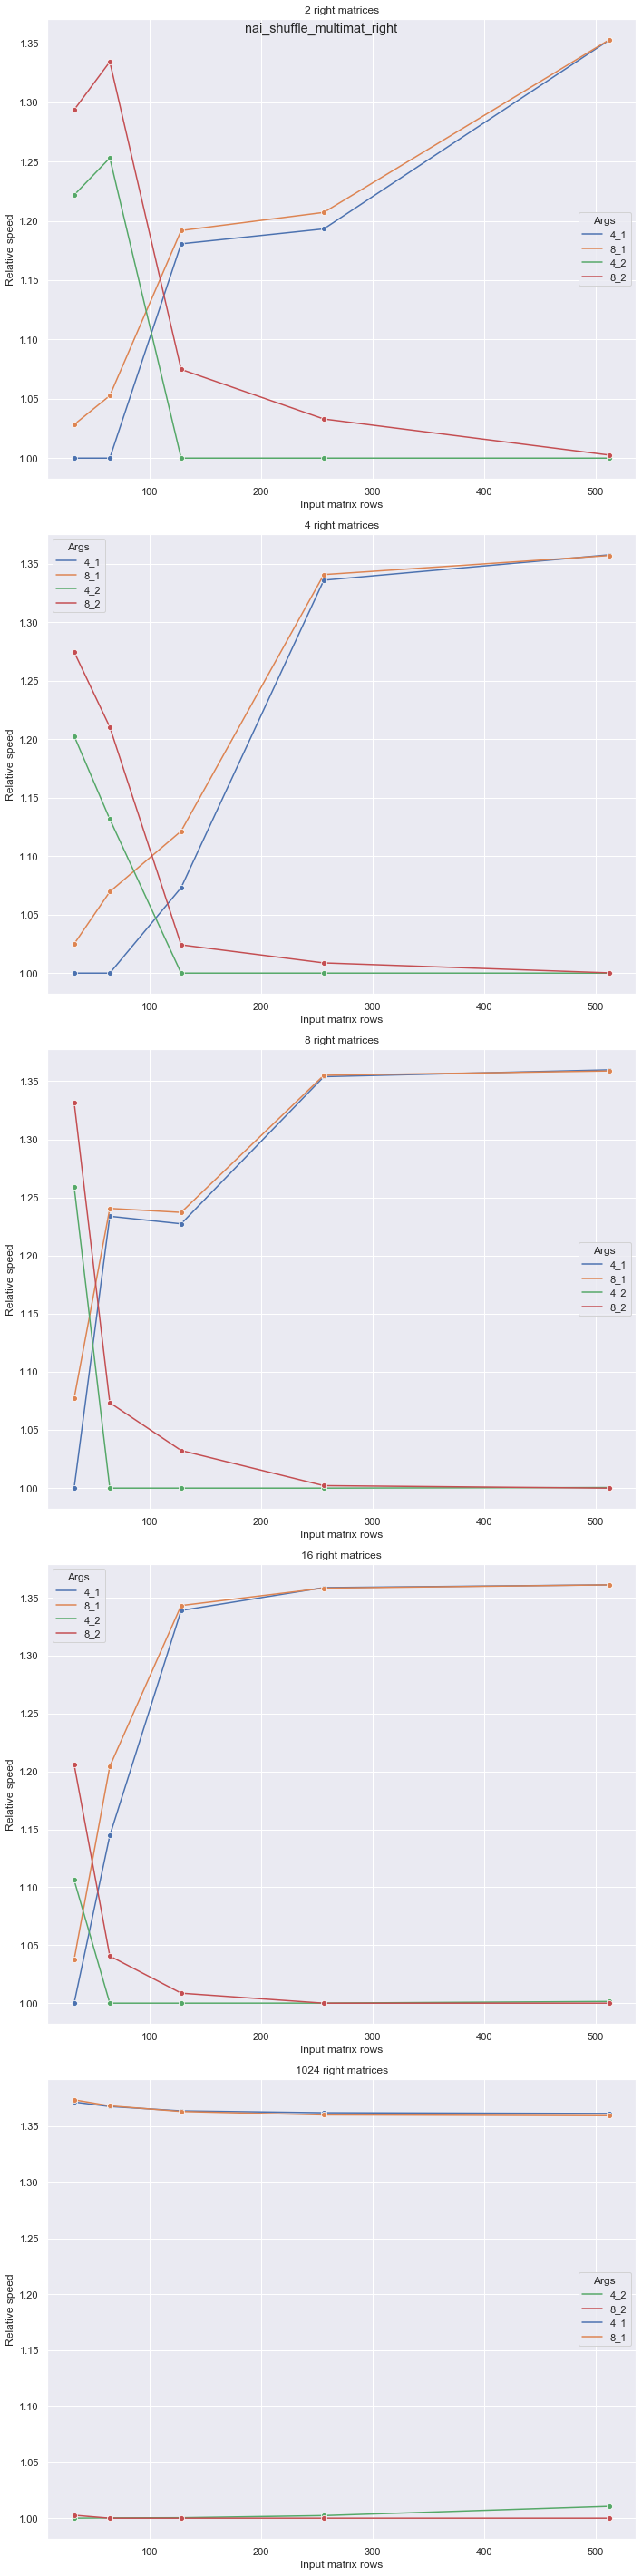

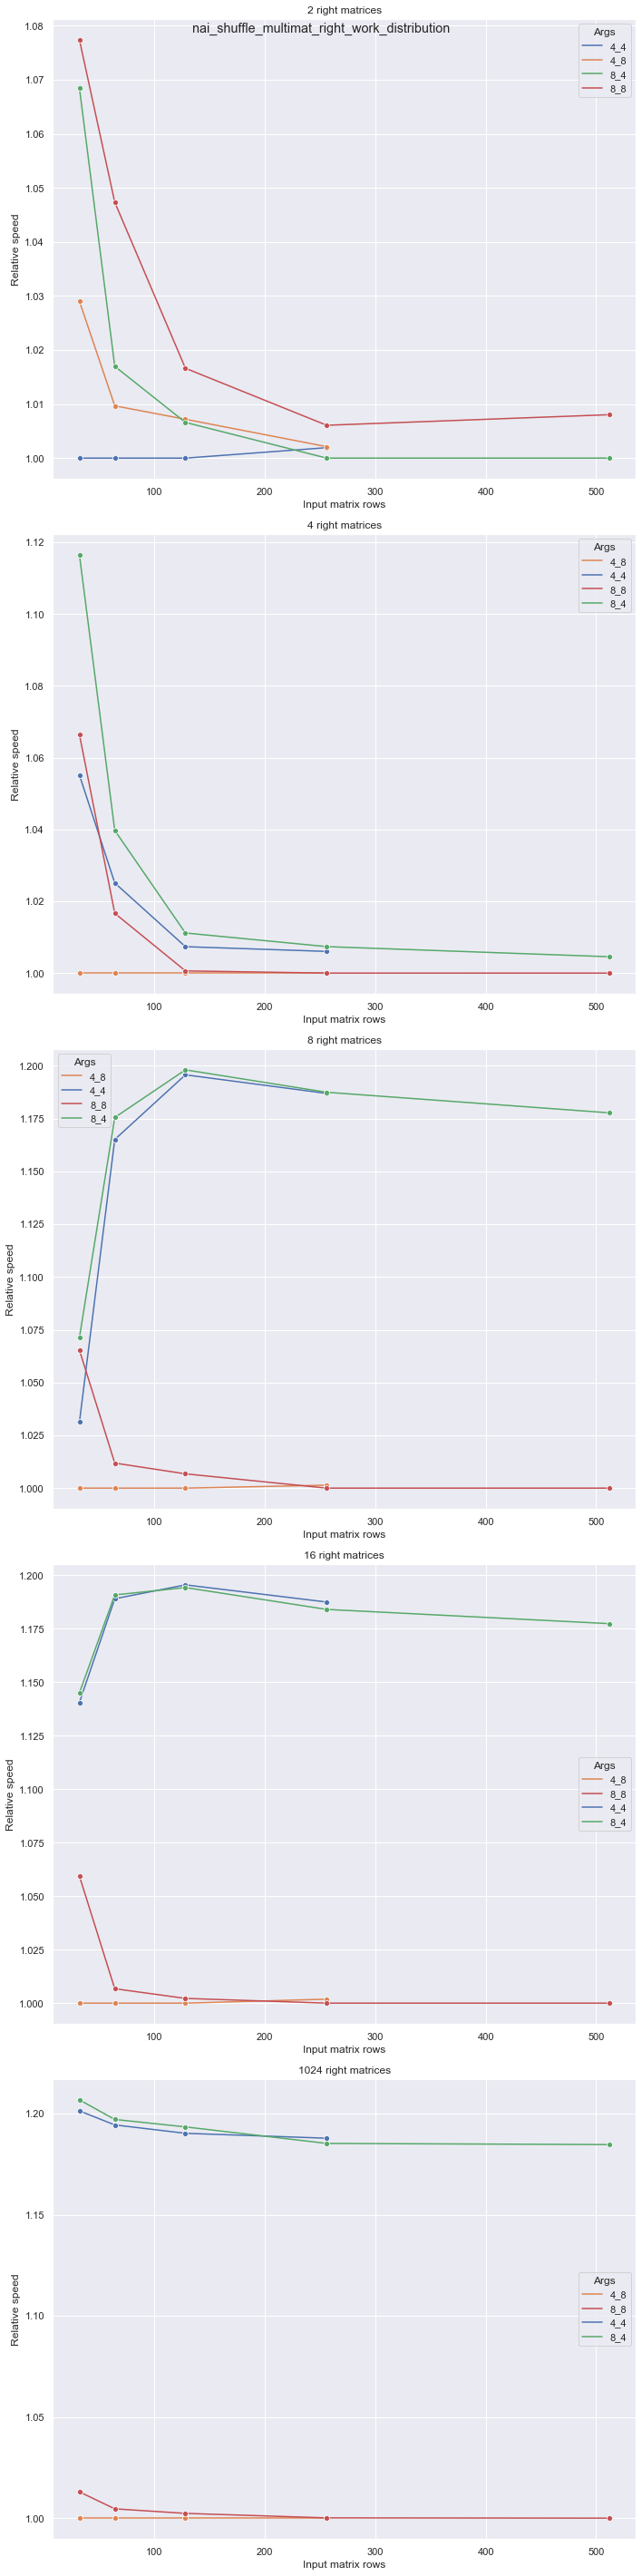

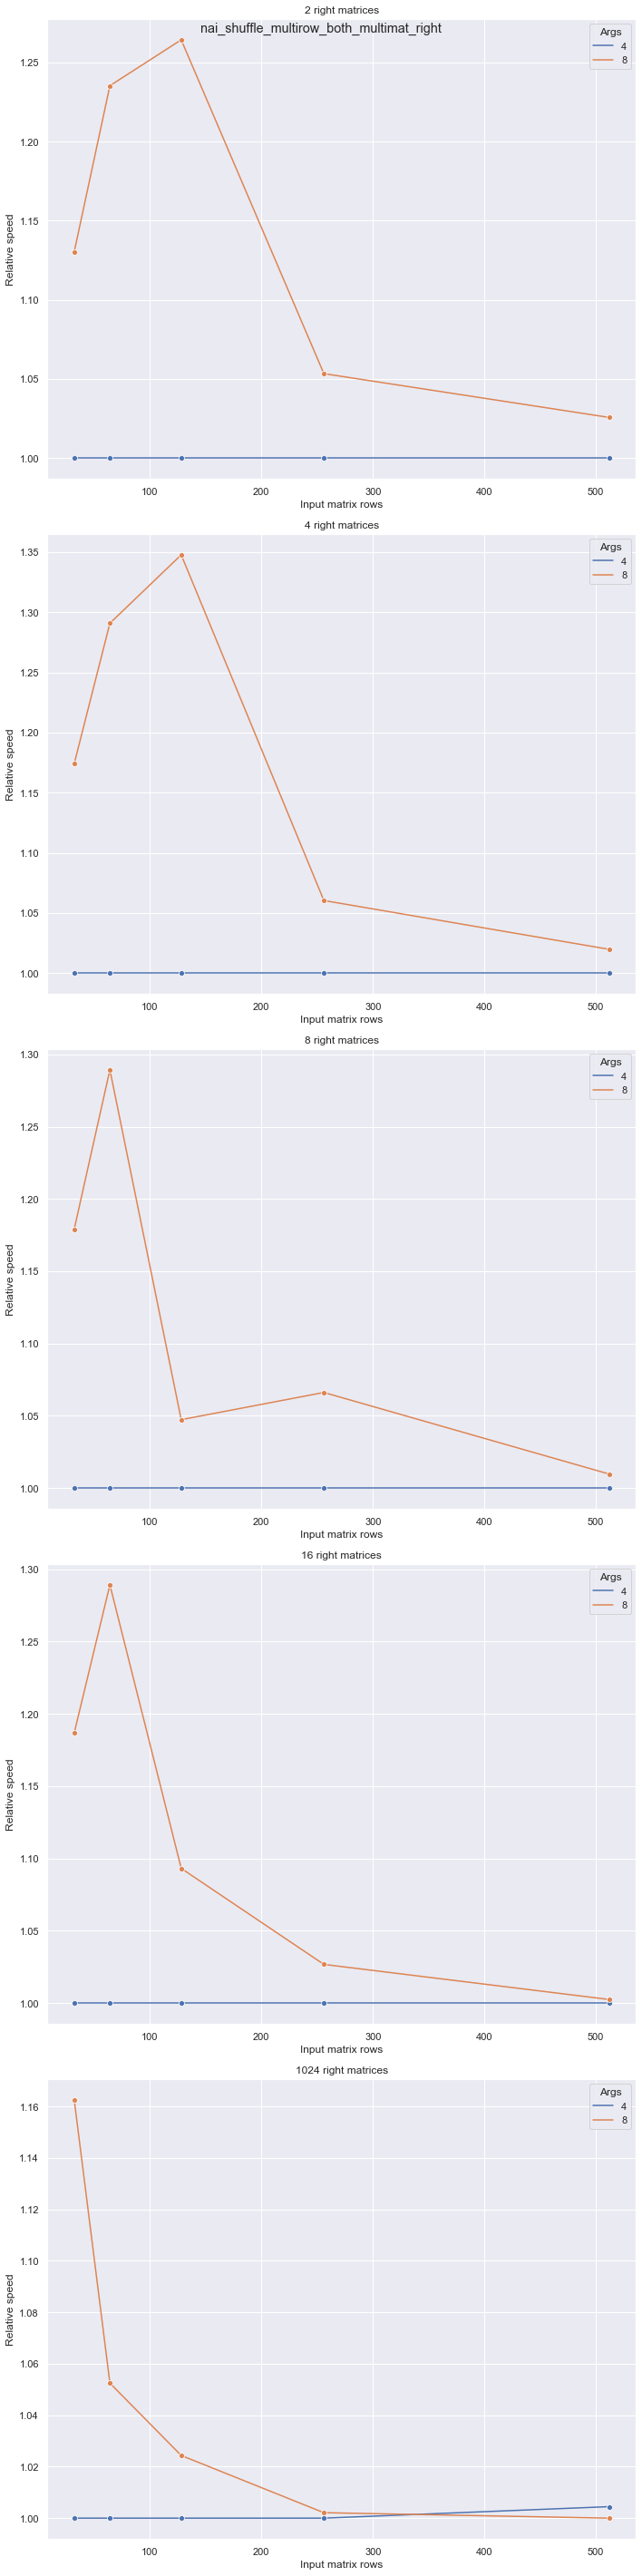

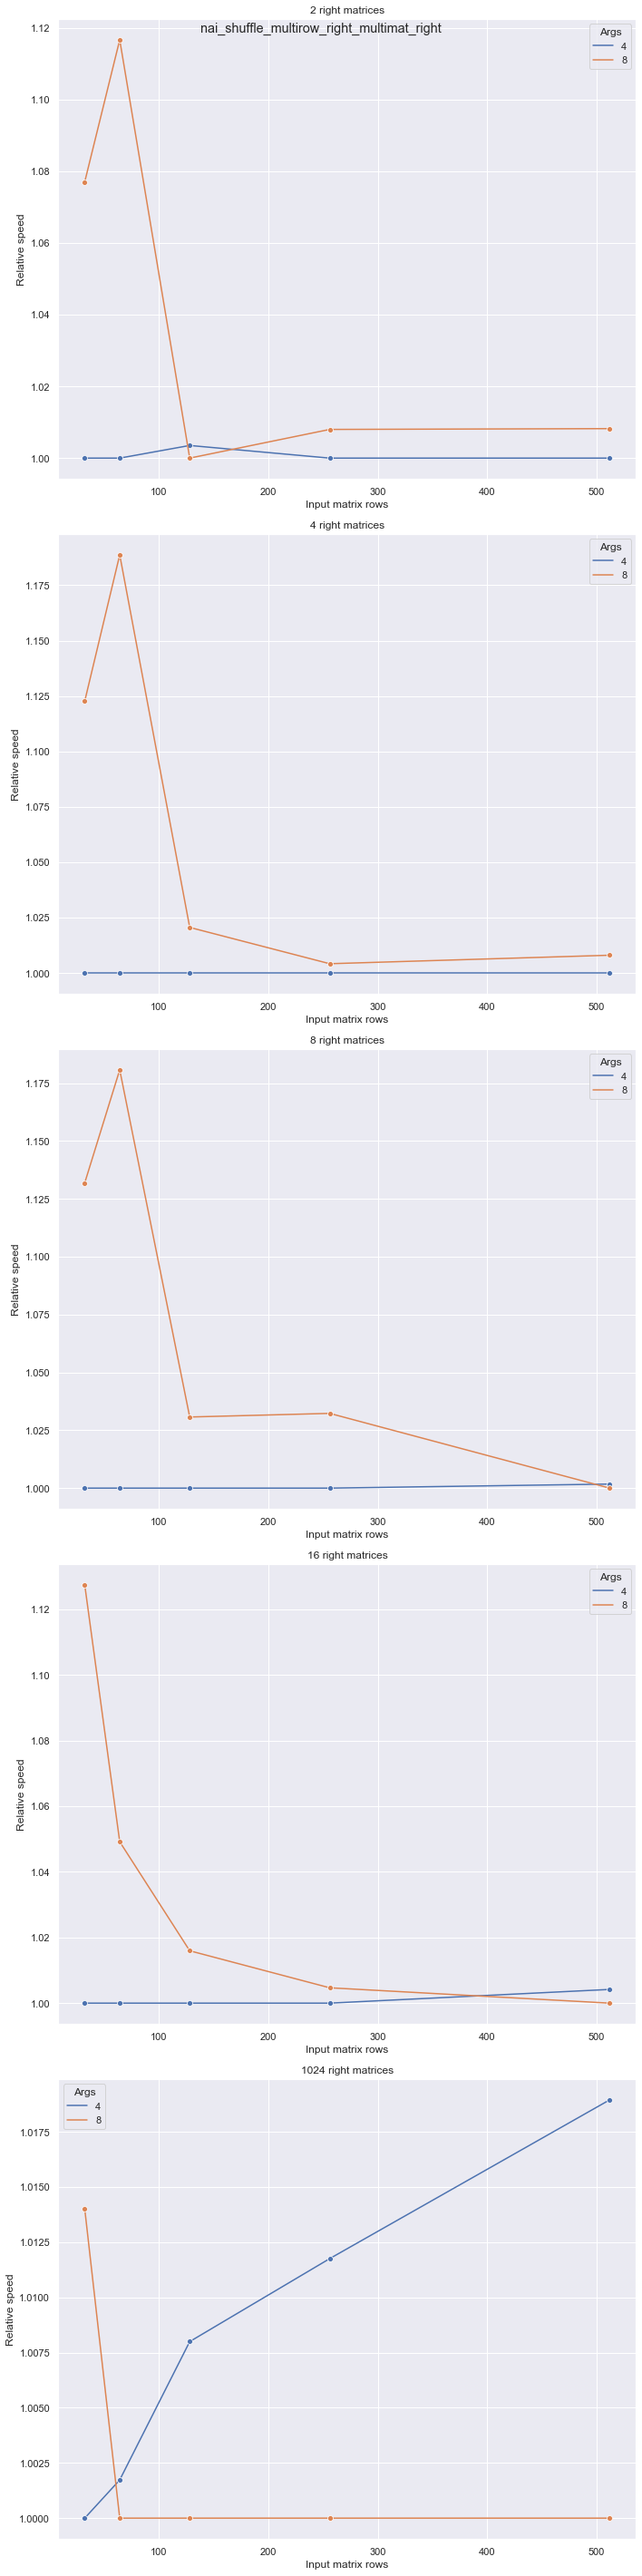

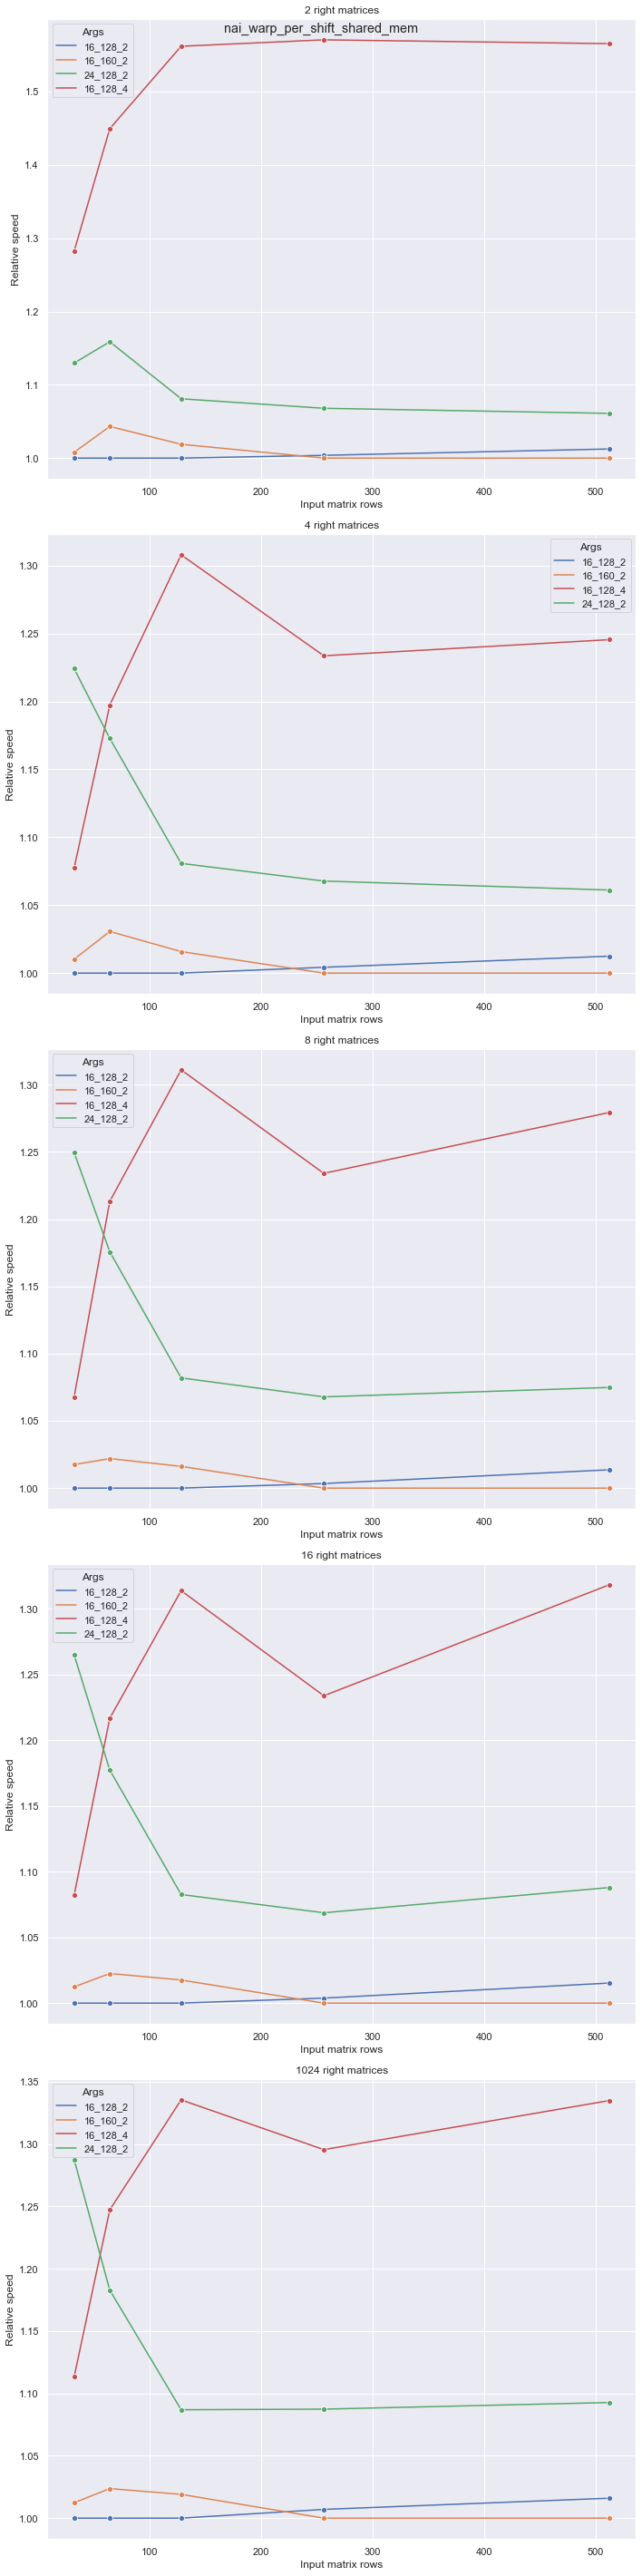

In [3]:
group = benchmark.groups["one_to_many"]

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

grouped = data.groupby(["Name", "Args", "Input right matrices", "Input matrix rows"])



kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index().sort_values("Kernel time")

min_times = results.groupby(["Name", "Input right matrices", "Input matrix rows"])["Kernel time"].min().to_frame("Kernel time").reset_index()


def speedup(row):
    min_time = min_times[(min_times["Name"] == row["Name"]) & (min_times["Input matrix rows"] == row["Input matrix rows"]) & (min_times["Input right matrices"] == row["Input right matrices"])]["Kernel time"].item()
    return row["Kernel time"] / min_time

results["Relative speed"] = results.apply(speedup, axis=1)


sns.set(rc={'figure.figsize': (10, 40)})

for name in sorted(results["Name"].unique()):

    alg_results = results[results["Name"] == name]
    fig, axs = plt.subplots(nrows=alg_results["Input right matrices"].nunique())

    palette = dict(zip(alg_results["Args"].unique(), sns.color_palette(n_colors=alg_results["Args"].nunique())))

    for idx, num_rights in enumerate(sorted(results["Input right matrices"].unique())):
        filtered_result = alg_results[alg_results["Input right matrices"] == num_rights]
        ax = sns.lineplot(data=filtered_result, x="Input matrix rows", y="Relative speed", hue="Args", marker='o', ax=axs[idx], palette=palette)

        ax.set_title(f"{num_rights} right matrices")
    fig.suptitle(f"{name}")
    fig.tight_layout()

best_args = results.groupby(["Name", "Args"])["Relative speed"].sum().to_frame("Total relative time").reset_index().sort_values("Total relative time")
print(best_args.groupby(["Name"]).head(3).sort_values("Name", kind="stable"))

# N TO MN

                                            Name            Args  \
7   nai_shuffle_multimat_right_work_distribution  4_8_1_triangle   
3   nai_shuffle_multimat_right_work_distribution  4_4_1_triangle   
15  nai_shuffle_multimat_right_work_distribution  8_8_1_triangle   
16      nai_shuffle_multirow_both_multimat_right            4_16   
18      nai_shuffle_multirow_both_multimat_right             4_8   
17      nai_shuffle_multirow_both_multimat_right             4_4   
22     nai_shuffle_multirow_right_multimat_right            4_16   
24     nai_shuffle_multirow_right_multimat_right             4_8   
25     nai_shuffle_multirow_right_multimat_right            8_16   
29                 nai_warp_per_shift_shared_mem        16_128_4   
30                 nai_warp_per_shift_shared_mem        16_128_8   
28                 nai_warp_per_shift_shared_mem       16_128_16   

    Total relative time  
7             20.832867  
3             21.451033  
15            26.276260  
16         

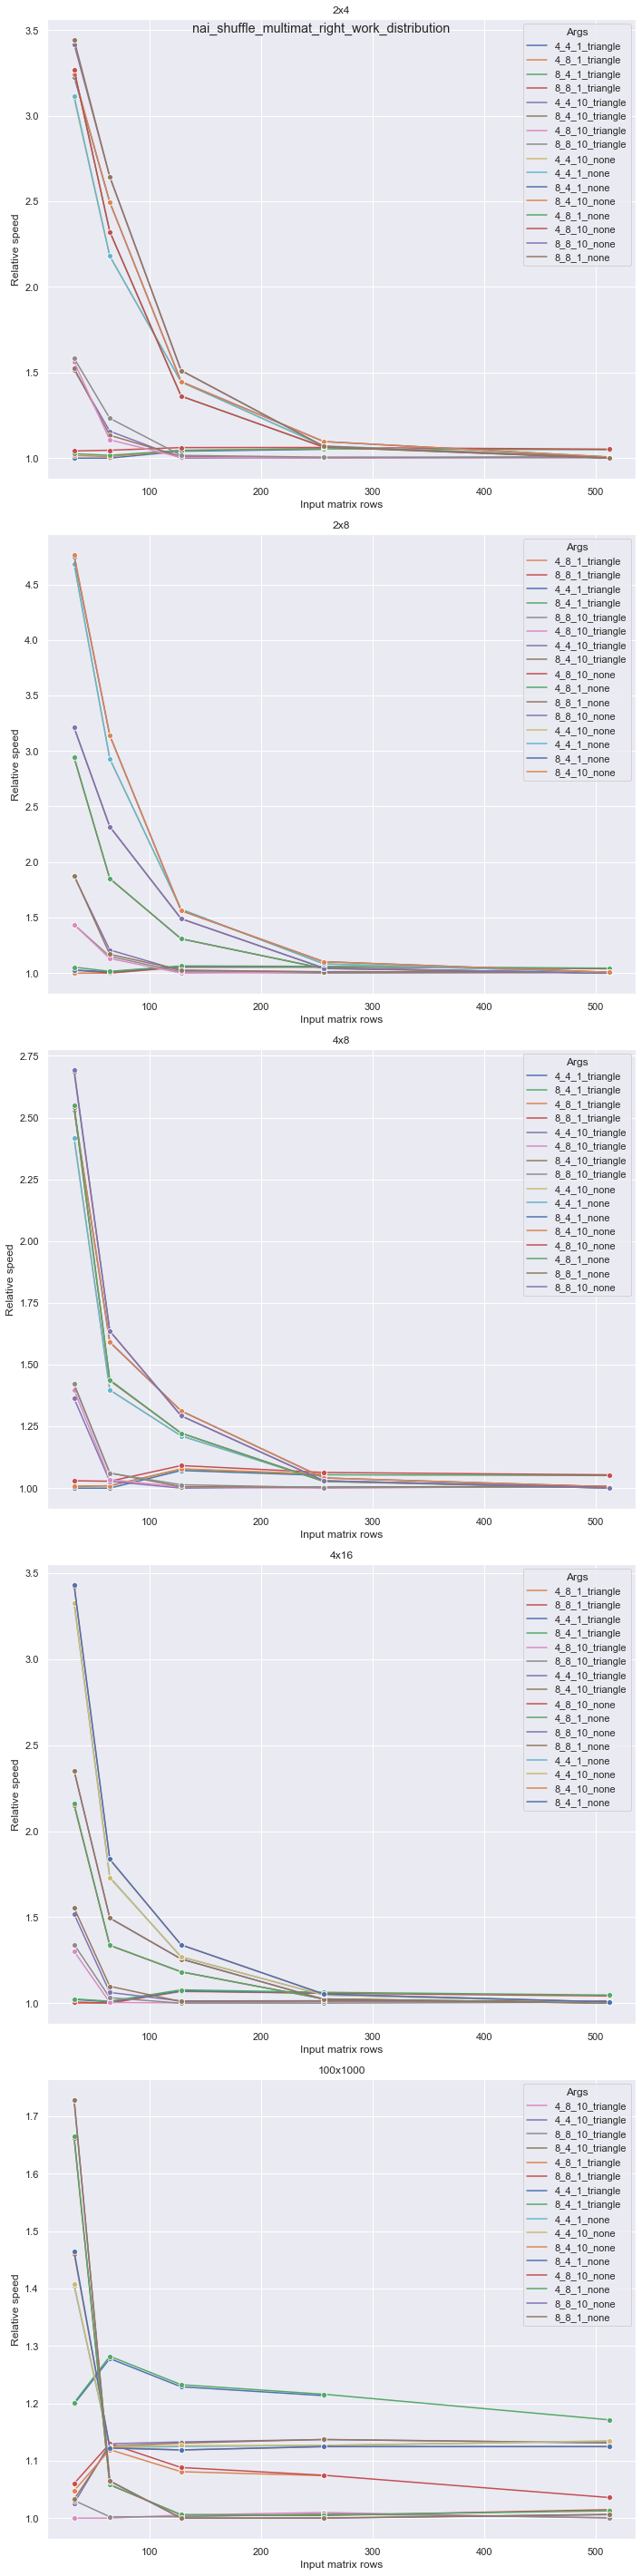

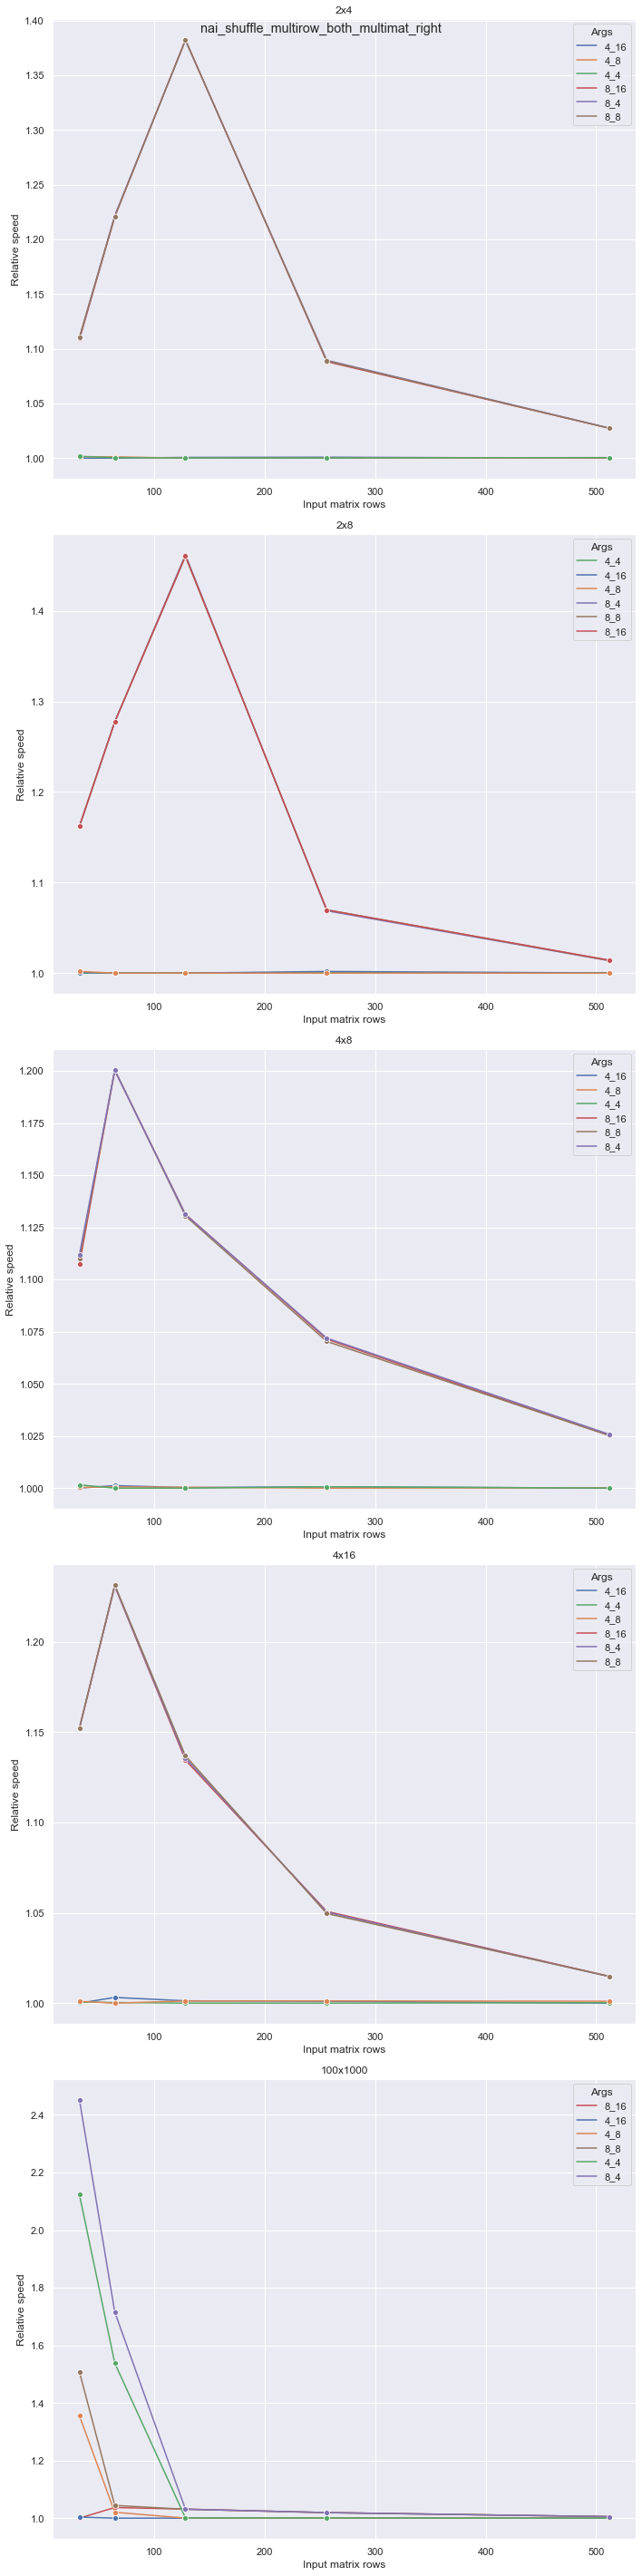

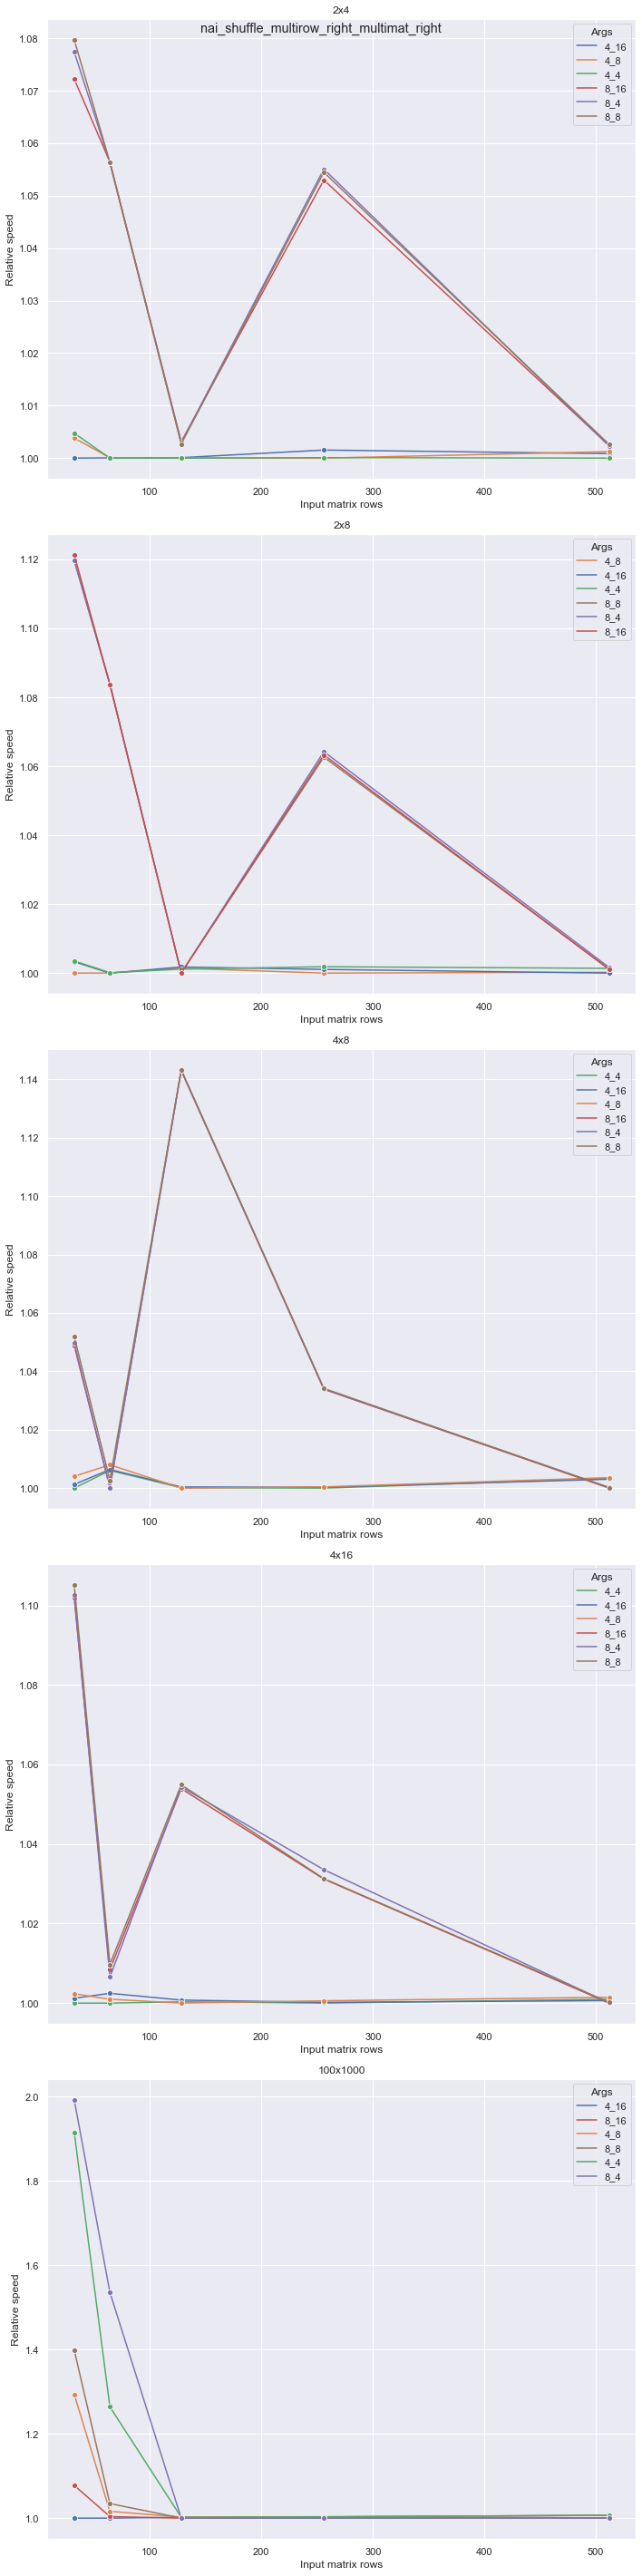

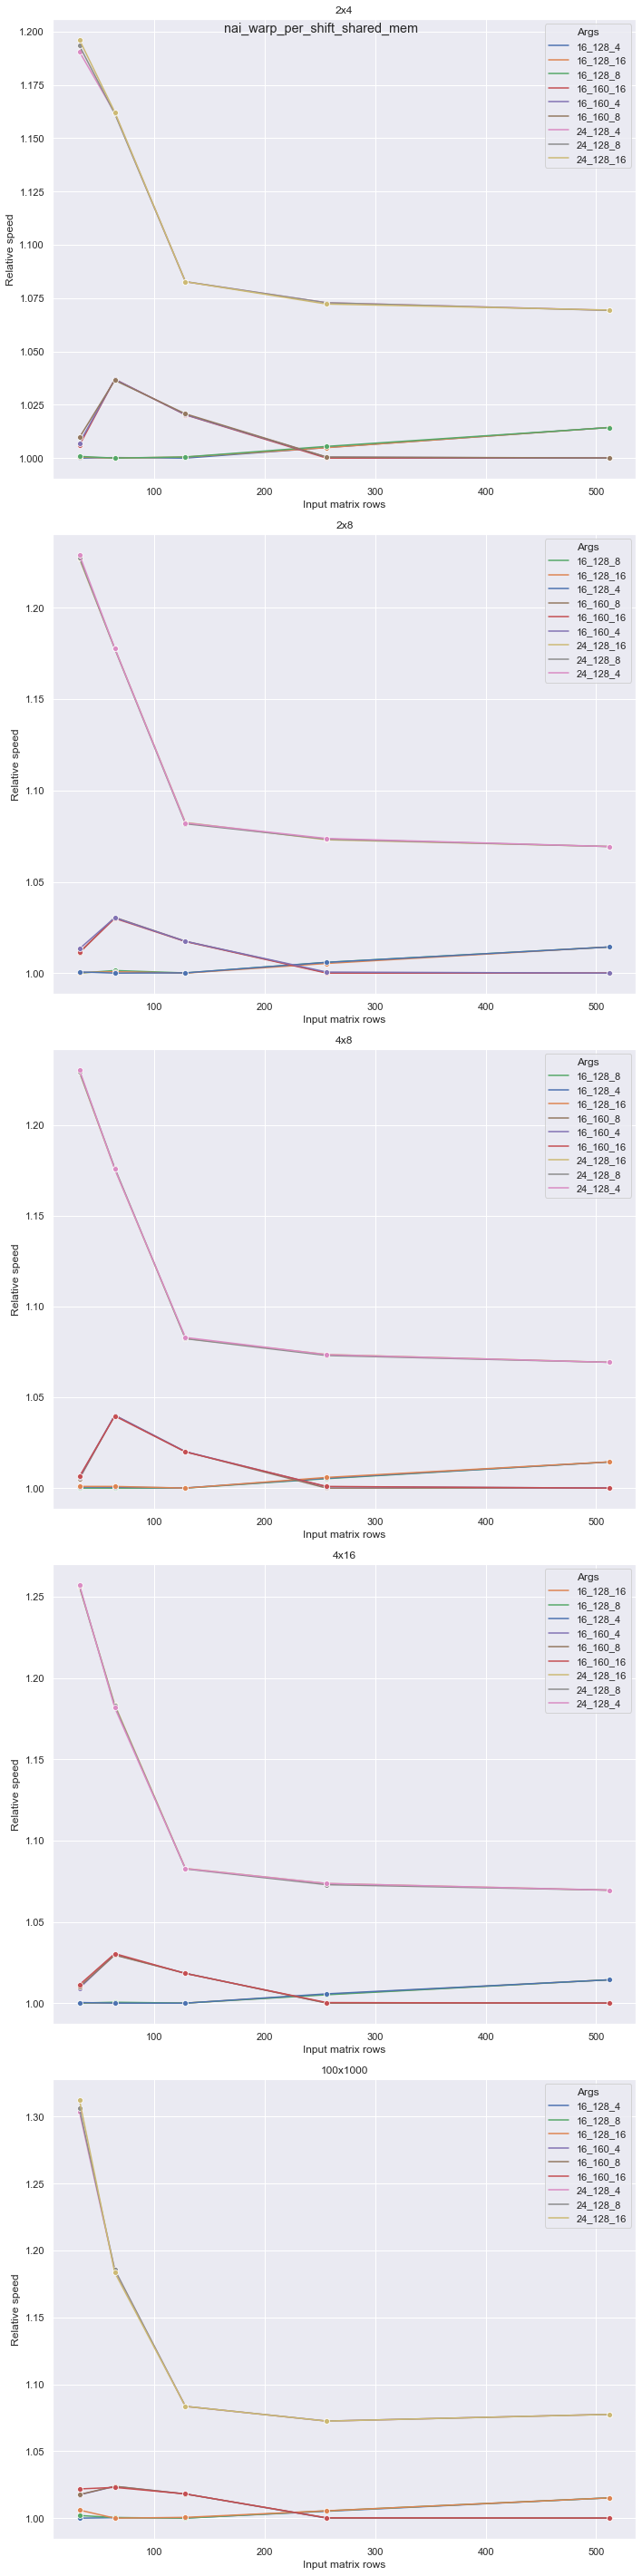

In [4]:
group = benchmark.groups["n_to_mn"]

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

num_input_types = data["Input type"].nunique()

grouped = data.groupby(["Name", "Args", "Input left matrices", "Input right matrices", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index().sort_values("Kernel time")

min_times = results.groupby(["Name", "Input left matrices", "Input right matrices", "Input matrix rows"])["Kernel time"].min().to_frame("Kernel time").reset_index()

def speedup(row):
    min_time = min_times[(min_times["Name"] == row["Name"]) & (min_times["Input matrix rows"] == row["Input matrix rows"]) & (min_times["Input right matrices"] == row["Input right matrices"]) & (min_times["Input left matrices"] == row["Input left matrices"])]["Kernel time"].item()
    return row["Kernel time"] / min_time

results["Relative speed"] = results.apply(speedup, axis=1)


sns.set(rc={'figure.figsize': (10, 40)})


for name in sorted(results["Name"].unique()):
    alg_results = results[results["Name"] == name]
    fig, axs = plt.subplots(nrows=num_input_types)

    palette = dict(zip(alg_results["Args"].unique(), sns.color_palette(n_colors=alg_results["Args"].nunique())))

    input_type = 0
    for num_lefts in sorted(alg_results["Input left matrices"].unique()):
        left_results = alg_results[alg_results["Input left matrices"] == num_lefts]
        for num_rights in sorted(left_results["Input right matrices"].unique()):
            right_results = left_results[left_results["Input right matrices"] == num_rights]
            ax = sns.lineplot(data=right_results, x="Input matrix rows", y="Relative speed", hue="Args", marker='o',
                              ax=axs[input_type], palette=palette)
            input_type += 1

            ax.set_title(f"{num_lefts}x{num_rights}")
    fig.suptitle(f"{name}")
    fig.tight_layout()

best_args = results.groupby(["Name", "Args"])["Relative speed"].sum().to_frame("Total relative time").reset_index().sort_values("Total relative time")
print(best_args.groupby(["Name"]).head(3).sort_values("Name", kind="stable"))

# N TO M

                                            Name             Args  \
1    nai_shuffle_multimat_both_work_distribution       4_triangle   
3    nai_shuffle_multimat_both_work_distribution       8_triangle   
0    nai_shuffle_multimat_both_work_distribution           4_none   
14  nai_shuffle_multimat_right_work_distribution   4_8_triangle_4   
15  nai_shuffle_multimat_right_work_distribution   4_8_triangle_8   
13  nai_shuffle_multimat_right_work_distribution  4_8_triangle_16   
32       nai_shuffle_multirow_both_multimat_both            4_2_2   
28       nai_shuffle_multirow_both_multimat_both            2_2_2   
33       nai_shuffle_multirow_both_multimat_both            4_2_4   
36                 nai_warp_per_shift_shared_mem        16_128_16   
38                 nai_warp_per_shift_shared_mem         16_128_8   
37                 nai_warp_per_shift_shared_mem         16_128_4   

    Total relative time  
1             21.060525  
3             26.720138  
0             50.975552 

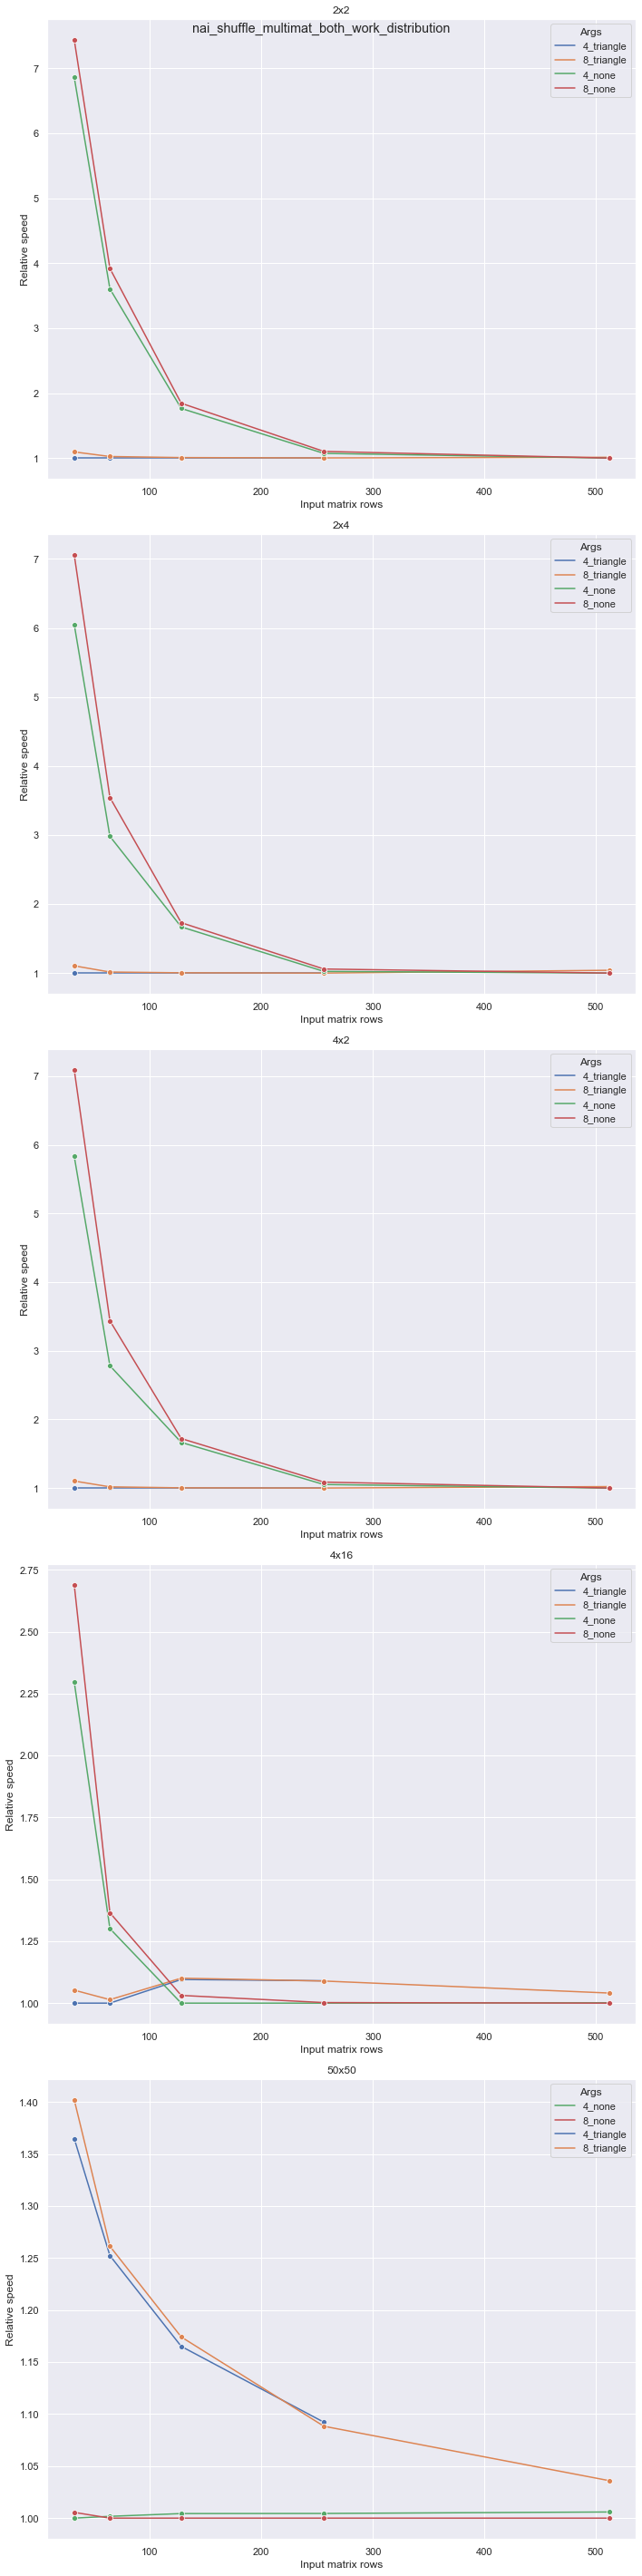

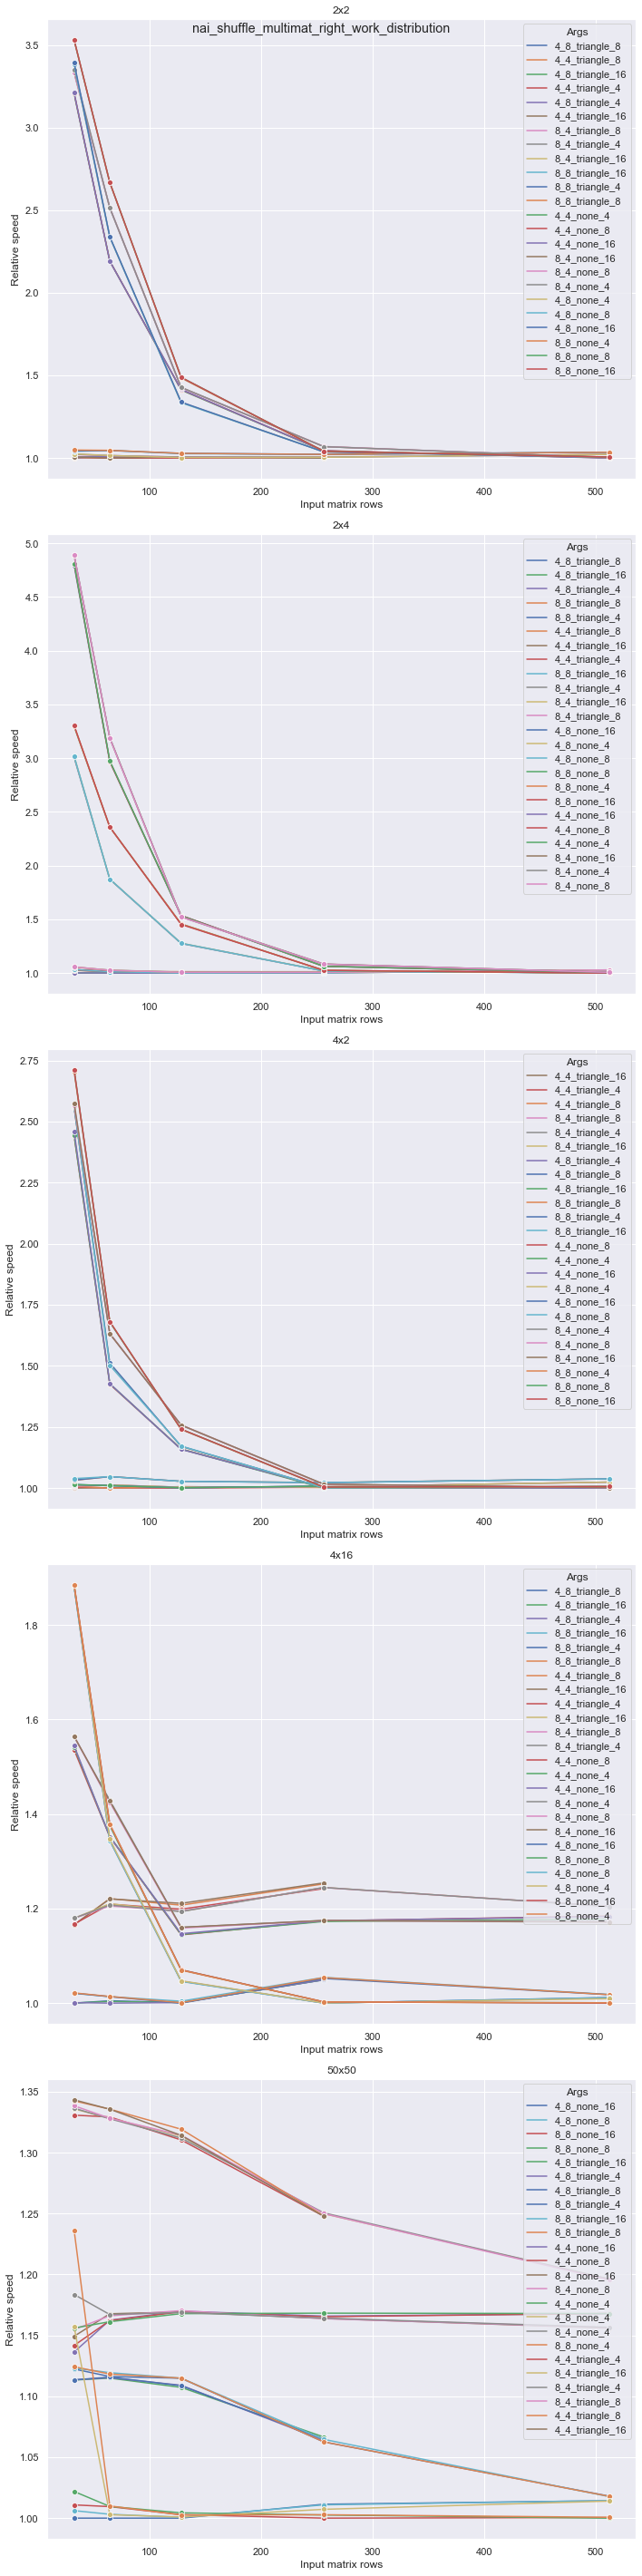

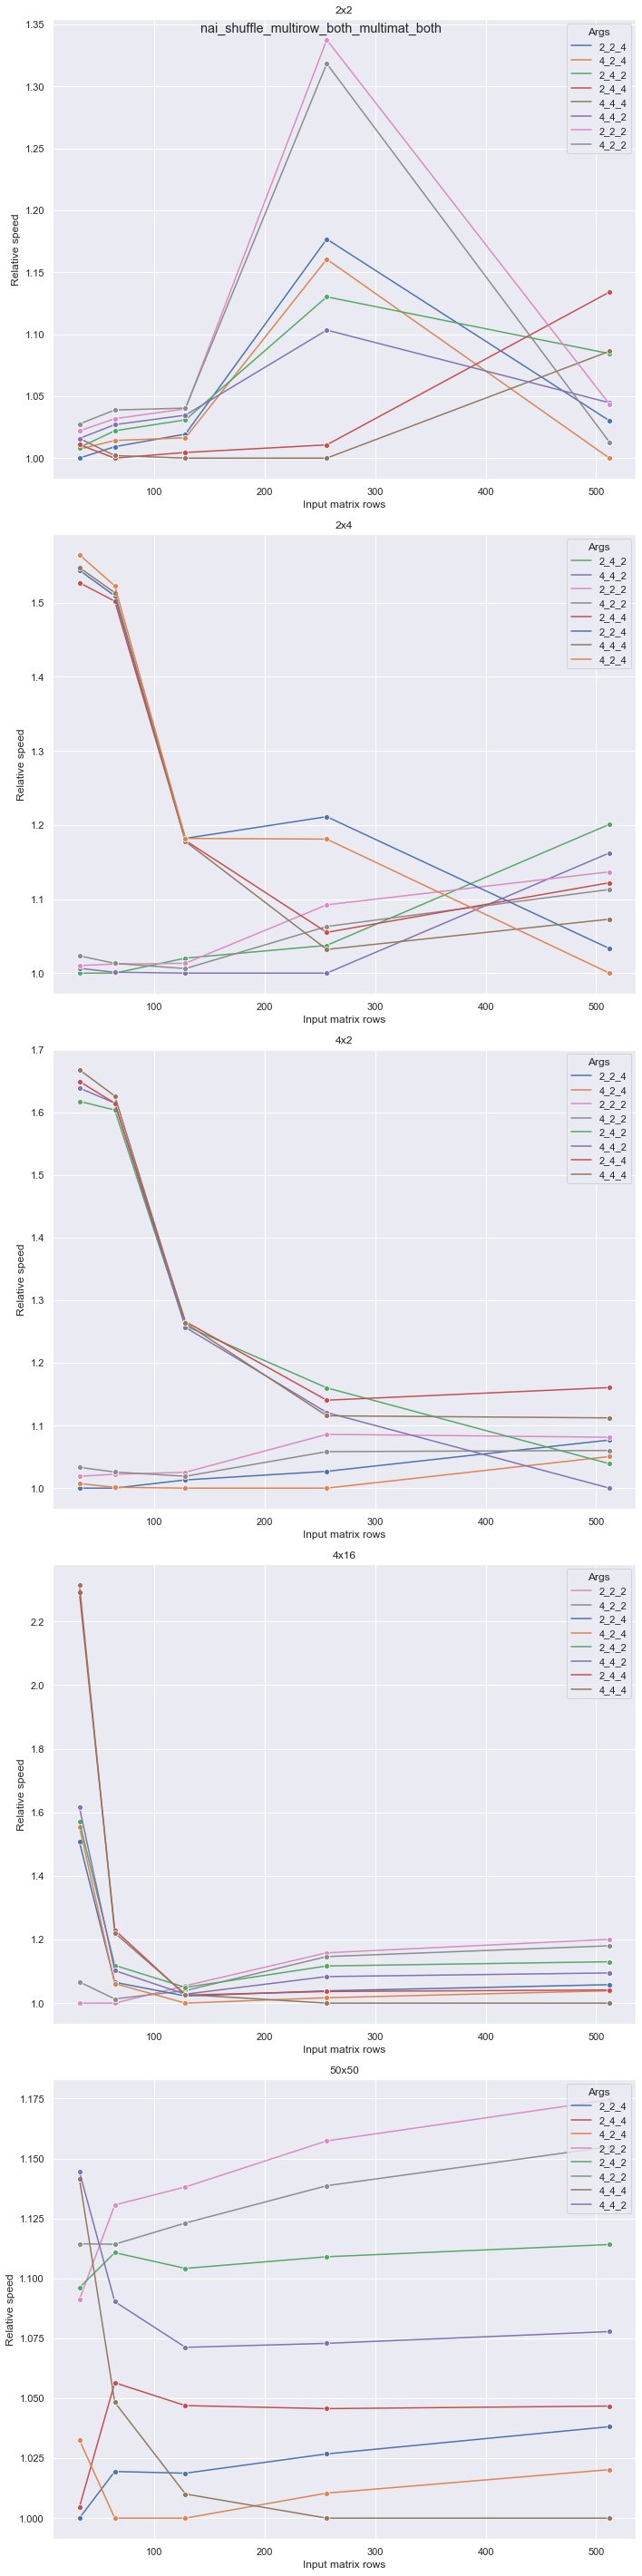

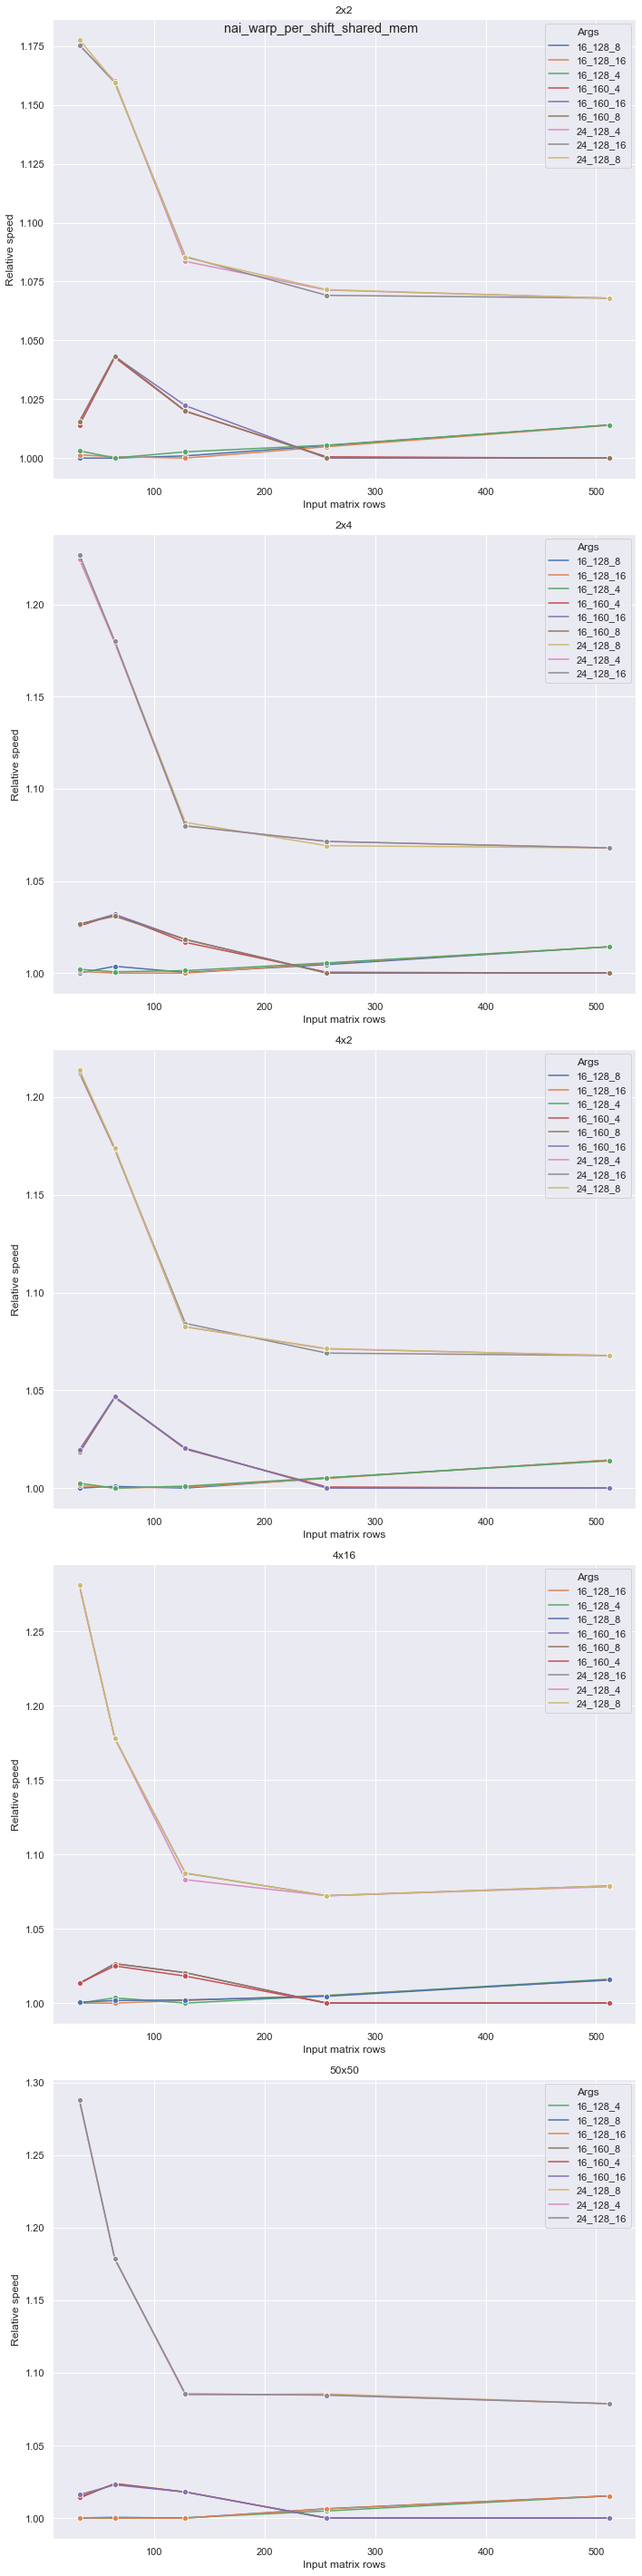

In [5]:
group = benchmark.groups["n_to_m"]

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

num_input_types = data["Input type"].nunique()

grouped = data.groupby(["Name", "Args", "Input left matrices", "Input right matrices", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index().sort_values("Kernel time")

min_times = results.groupby(["Name", "Input left matrices", "Input right matrices", "Input matrix rows"])["Kernel time"].min().to_frame("Kernel time").reset_index()

def speedup(row):
    min_time = min_times[(min_times["Name"] == row["Name"]) & (min_times["Input matrix rows"] == row["Input matrix rows"]) & (min_times["Input right matrices"] == row["Input right matrices"]) & (min_times["Input left matrices"] == row["Input left matrices"])]["Kernel time"].item()
    return row["Kernel time"] / min_time

results["Relative speed"] = results.apply(speedup, axis=1)


sns.set(rc={'figure.figsize': (10, 40)})


for name in sorted(results["Name"].unique()):
    alg_results = results[results["Name"] == name]
    fig, axs = plt.subplots(nrows=num_input_types)

    palette = dict(zip(alg_results["Args"].unique(), sns.color_palette(n_colors=alg_results["Args"].nunique())))

    input_type = 0
    for num_lefts in sorted(alg_results["Input left matrices"].unique()):
        left_results = alg_results[alg_results["Input left matrices"] == num_lefts]
        for num_rights in sorted(left_results["Input right matrices"].unique()):
            right_results = left_results[left_results["Input right matrices"] == num_rights]
            ax = sns.lineplot(data=right_results, x="Input matrix rows", y="Relative speed", hue="Args", marker='o',
                              ax=axs[input_type], palette=palette)
            input_type += 1

            ax.set_title(f"{num_lefts}x{num_rights}")
    fig.suptitle(f"{name}")
    fig.tight_layout()

best_args = results.groupby(["Name", "Args"])["Relative speed"].sum().to_frame("Total relative time").reset_index().sort_values("Total relative time")
print(best_args.groupby(["Name"]).head(3).sort_values("Name", kind="stable"))